# Explainability Lab
**Date:** 2025-11-28

**What this notebook covers**


**Part 0** (common for each part):
  - Setup & Imports
  - Load & preprocess the UCI Adult dataset.

**Part 1** (Perturbation explanations (LIME/SHAP))
- Train a Random Forest Classifier.
- Generate and visualize feature attributions with **SHAP** and **Lime**.

**Part 2** (Gradient-based explanations using Captum/Zennit)
- Train a PyTorch MLP classifier.
- Generate and visualize feature attributions using **Captum** gradient-based methods:
  - Saliency
  - SmoothGrad (NoiseTunnel)
  - InputxGradients
  - Integrated Gradients.
- Generate and visualize feature attributions using **Zennit** LRP methods:
  - LRP (Layer-wise Relevance Propagation).
- Evaluate every XAI methods with **Quantus/Captum** metrics.

**Part 3** (Counterfactual explanations)
- Generate and evaluate counterfactual explanations for tabular data using **Dice**.

**Part 4** (Attacks on XAI)
- Implement an attack to fool LIME/SHAP explanations.

**Part 5** (Explanations on LLMs)
- Generate and visualize feature attributions for LLM using **Captum** and **LXT**.



> Notes:
- This lab is longer for the schedule time, so we don't expect you to finish it. Since each part is independent from the other, focus on what interest you the most and do not hesitate to ask questions.
- This notebook expects an environment with internet to fetch the dataset.
- For part 5, it expects to have GPU on your machine.


# Part 0

## Setup & Imports

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from captum.attr import (
    Saliency,
    IntegratedGradients,
    NoiseTunnel,
    InputXGradient,
)

from zennit.attribution import Gradient

import quantus

from typing import List, Callable, Dict, Tuple


/home/jky/ai-security-labs/src/0x_xai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # safe even if no GPU

## Load & Preprocess the Adult dataset

In this section we:
1. Download the UCI Adult dataset via OpenML.
2. Clean basic missing values.
3. Separate target vs features.
4. Apply preprocessing (scaling numeric features, encoding categorical ones).


In [ ]:
# Fetch Adult from OpenML
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame.copy()

# Replace '?' with NaN and drop rows with missing (simple but aggressive approach).
# In practice you may want something more subtle (imputation, etc.).
df = df.replace('?', np.nan).dropna()

# Target is 'class': '>50K' or '<=50K' —> convert to 0/1
df['class'] = (df['class'] == '>50K').astype(int)

# Identify categorical vs numeric columns
target_col = 'class'
X_df = df.drop(columns=[target_col])
y = df[target_col].values

# Identify categorical vs numeric columns (based on dtype).
cat_cols = X_df.select_dtypes(include=['category','object']).columns.tolist()
num_cols = [c for c in X_df.columns if c not in cat_cols]


Build preprocessing pipeline:
- `StandardScaler` for numeric columns (zero mean, unit variance).
- `OrdinalEncoder` for categorical columns.

We **could** use `OneHotEncoder`, but that can create many sparse features.
Here we use OrdinalEncoder to keep the feature space compact, which simplifies some XAI methods.

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        # ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('cat', OrdinalEncoder(), cat_cols), # We use here OrdinalEncoder to limit the number of features
    ]
)

X_processed = preprocess.fit_transform(X_df)

# Store the feature names after preprocessing for later interpretation.
feature_names_num = num_cols
feature_names_cat = list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
feature_names_all = feature_names_num + feature_names_cat

# Split into train test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

We now convert the NumPy arrays to PyTorch tensors and build DataLoaders for the MLP.

In [ ]:
# Create the torch tensors

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

if (y_train_t.ndim == 1) or (y_train_t.shape[1] == 1):
    y_train_t = torch.column_stack((1 - y_train_t, y_train_t))

In [ ]:
# Wrap tensors into TensorDataset and DataLoader for batching.

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)


# Part 1

## Scikit Learn Random Forest Model & Training

We first train a classical `RandomForestClassifier` tree ensemble on the preprocessed features. This will be our baseline model for **SHAP** and **LIME** explanations.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get predicted probabilities and hard predictions on the test set.
y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
#y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))


## SHAP/LIME explanations

### SHAP Explainer

In [ ]:
import shap
shap.initjs()

# Explain the model's predictions using SHAP.
# For tree-based models, SHAP can use highly optimized algorithms.
explainer = shap.Explainer(rf, feature_names=feature_names_all)
shap_values = explainer(X_test[:100]) # Explain first 100 test instances for time constraint


In [ ]:
# Waterfall plot
shap.plots.waterfall(shap_values[0, :, 0])

In [ ]:
# Force plot
shap.plots.force(shap_values[0, :, 0])

In [ ]:
# visualize all the explanations
shap.plots.force(shap_values[:, :, 0])

In [ ]:
# Beeswarm plot
shap.plots.beeswarm(shap_values[:, :, 0])

In [ ]:
# Bar plot
shap.plots.bar(shap_values[:, :, 0])

### LIME

We now apply LIME to the same Random Forest model.
LIME learns a local surrogate model around one specific input.

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Note: here we pass `X_train` as the background data in the preprocessed space.
explainer_lime = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names_all,
    class_names=['<=50K','>50K'],
    categorical_features=feature_names_cat,
    discretize_continuous=True,
    random_state=SEED)

idx = 0 ## index of the test instance to explain
x_raw = X_test[idx]
exp = explainer_lime.explain_instance(
    data_row=np.array(x_raw),
    predict_fn=rf.predict_proba,
    num_features=10)



In [ ]:
# Compatibility shim for LIME + modern IPython
from IPython.display import display, HTML

html = exp.as_html()
display(HTML(html))

# # monkey-patch only if missing
# if not hasattr(_icd, "display"):
#     _icd.display = display
# if not hasattr(_icd, "HTML"):
#     _icd.HTML = HTML

# exp.show_in_notebook(show_table=True, show_all=False)


# Part 2

## PyTorch MLP Model & Training

We now build a simple fully-connected neural network for the same task,
which we will then analyze using **Captum** and **Zennit**.

>Note: this is not a highly tuned architecture; the goal is to have
a reasonably accurate yet simple model, not to win Kaggle.

In [ ]:
class MLPModel(nn.Module):
    """
    Simple fully-connected MLP for tabular classification.

    The network consists of:
      - An input layer projecting from `input_dim` to `hidden_dim`.
      - `n_layers - 1` hidden layers of size `hidden_dim` with ReLU activations.
      - A final linear layer projecting to `output_dim` (number of classes).
      - A softmax over the output to obtain class probabilities.

    Args:
        n_layers (int): Total number of linear layers (including output).
        input_dim (int): Number of input features.
        hidden_dim (int): Number of units in each hidden layer.
        output_dim (int): Number of output classes.
    """
    def __init__(self, n_layers, input_dim, hidden_dim, output_dim):
        super().__init__()     

        layers = []

        # Input Layer (= first hidden layer)
        layers += [nn.Linear(input_dim, hidden_dim), nn.ReLU()]

        # Hidden Layers (number specified by n_layers)
        for _ in range(n_layers -1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU() ]

        # Output Layer
        layers += [nn.Linear(hidden_dim, output_dim)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the MLP.

        Args:
            x: Input tensor of shape (batch_size, input_dim).

        Returns:
            Tensor of shape (batch_size, output_dim) with class probabilities.
        """
        x = self.network(x)
        x = F.softmax(x, dim=1)

        return x


In [ ]:
class AverageMeter(object):
    """
    Utility class to keep track of running averages (e.g. loss during training).
    """
    def __init__(self):
        # Current value, average, cumulative sum, and count.
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        """
        Reset the class attributes.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n_count=1):
        """
        Update the values.

        Args:
            val (float): Current value.
            n_count (int, optional): Number of current value. Defaults to 1.
        """
        self.val = val
        self.sum += val * n_count
        self.count += n_count
        self.avg = self.sum / self.count


In [ ]:
def train(model: nn.Module,
          train_loader: DataLoader,
          num_epochs: int,
          criterion: nn.Module,
          optimizer: optim.Optimizer,
          device: torch.device
          ) -> None:
    """
    Simple training loop for a PyTorch model.

    Args:
        model: Model to train.
        train_loader: DataLoader yielding (inputs, targets) batches.
        num_epochs: Number of epochs to train.
        criterion: Loss function.
        optimizer: Optimizer (e.g. Adam).
        device: Device on which to run the computation.
    """
    model.train()
    loss_meter = AverageMeter()
    for epoch in range(num_epochs):
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            # print(logits.shape, y_batch.shape)
            loss = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item())
        print(f"Epoch {epoch+1}/{num_epochs} | loss={loss_meter.avg:.3f}")


def predict(model: nn.Module,
            test_loader: DataLoader,
            device: torch.device
            ) -> np.ndarray:
    """
    Compute class predictions for all samples in a DataLoader.

    Args:
        model: Trained model.
        test_loader: DataLoader for the evaluation set.
        device: Device on which to run inference.

    Returns:
        NumPy array of predicted class indices of shape (N,).
    """
    model.eval()
    predictions = []
    # y_true = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            preds = model(batch_X.to(device))
            # preds = torch.sigmoid(logits)
            predictions.append(preds.detach().cpu().numpy())

            # y_true.append(batch_y.cpu().numpy())

    probas = np.concatenate(predictions)

    # If binary task returns only probability for the true class, adapt it to return (N x 2)
    if probas.shape[1] == 1:
        probas = np.concatenate((1 - probas, probas), 1)

    predictions = np.argmax(probas, axis=1)
    return predictions


In [ ]:
# Configure model and training hyperparameters.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_layers = 4
input_dim = X_train_t.shape[1]
hidden_dim = 47
output_dim = 2 # number of classes
num_epochs = 20
lr = 1e-3

model = MLPModel(n_layers=n_layers,
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                output_dim=output_dim
                ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Train the neural network.
train(model,
      train_loader=train_loader,
      num_epochs=num_epochs,
      criterion=criterion,
      optimizer=optimizer,
      device=device)

In [ ]:
# Evaluate on the test set.
pred = predict(model, test_loader, device)

acc = (pred==y_test).mean()
print(f"Accuracy on the test set : {acc*100 :2f}%")

In [ ]:
print(classification_report(y_test, pred, digits=3))


In [ ]:
# Convert predicted labels to a tensor (used later as "target" for some XAI methods).
y_pred_t = torch.from_numpy(pred).to(device)

## Captum Attributions

We now use [Captum](https://captum.ai/) to compute gradient-based feature attributions for the MLP.
We will:
- Implement helper visualization utilities (global bar plots + beeswarm-style scatter).
- Compute **Saliency**, **SmoothGrad**, **Input×Gradient**, and **Integrated Gradients**.
- Compare them qualitatively and quantitatively.

### Visualization utils

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names: List[str],
                        importances: np.ndarray,
                        title: str = "Average Feature Importances",
                        plot: bool = True,
                        axis_title: str = "Features"
                        ) -> None:
    """
    Print and optionally plot average feature importances.

    Args:
        feature_names: List of feature names (length = n_features).
        importances: Array of importances of shape (n_features,).
        title: Title for the plot/printout.
        plot: If True, displays a bar plot using Matplotlib.
        axis_title: Label for the x-axis.
    """
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.4f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True, rotation=45)
        plt.xlabel(axis_title)
        plt.title(title)


def beeswarm_attributions(
        attrs: np.ndarray,
        X: np.ndarray,
        feature_names: List[str],
        max_display: int = 20,
        color_by: str = "feature",
        cmap=None,
        jitter: float = 0.25,
        dot_size: int = 8,
        title: str = "Beeswarm of Attributions",
        xlabel: str = "Attribution (signed)",
):
    """
    SHAP-style beeswarm plot for tabular attributions.

    Args:
        attrs: Array of shape (n_samples, n_features) with signed attributions.
        X: Original input values (same shape as attrs).
        feature_names: List of feature names.
        max_display: Maximum number of features to display (sorted by mean |attr|).
        color_by: Whether to color points by "feature" values, "attr" values, or None.
        cmap: Matplotlib colormap name or object.
        jitter: Vertical jitter scale to avoid overlap.
        dot_size: Marker size.
        title: Plot title.
        xlabel: Label for the x-axis.
    """
    attrs = np.asarray(attrs)
    X = np.asarray(X)
    assert attrs.shape == X.shape, "attrs and X must have same shape [n_samples, n_features]"
    n_samples, n_features = attrs.shape
    feature_names = list(feature_names)

    # Rank features by mean absolute attribution
    mean_abs = np.mean(np.abs(attrs), axis=0)
    order = np.argsort(-mean_abs)[:max_display]
    attrs_sub = attrs[:, order]
    X_sub = X[:, order]
    names_sub = [feature_names[i] for i in order]

    # Prepare figure
    plt.figure(figsize=(10, 0.4 * len(names_sub) + 2))
    y_base = np.arange(len(names_sub))  # one row per feature (top is most important)
    y_plot_positions = []

    # Normalize color reference per-feature (like SHAP)
    def normalize_col(v):
        v = v.astype(float)
        vmin, vmax = np.nanmin(v), np.nanmax(v)
        if vmax == vmin:
            return np.zeros_like(v)  # flat color if constant
        return (v - vmin) / (vmax - vmin)

    for j, (a_col, x_col) in enumerate(zip(attrs_sub.T, X_sub.T)):
        # Jitter to avoid overplotting; more points near 0 should stack, not overlap
        # Use rank-based spread to get a “swarm” feel
        # We place points around y = (len(names_sub)-1 - j) so most important is at top
        y0 = (len(names_sub) - 1 - j)
        # Create a small symmetric jitter using ranks of attribution values
        ranks = a_col.argsort().argsort()  # 0..n-1 ranks
        # Center ranks around 0 and scale
        jitter_offsets = (ranks - np.median(ranks)) / (np.max(ranks) + 1e-9)
        y_vals = y0 + jitter * jitter_offsets
        y_plot_positions.append(y0)

        # Colors
        if color_by == "feature":
            cvals = normalize_col(x_col)
            sc = plt.scatter(a_col, y_vals, s=dot_size, c=cvals, cmap=cmap, alpha=0.8, edgecolors='none')
        elif color_by == "attr":
            cvals = normalize_col(a_col)
            sc = plt.scatter(a_col, y_vals, s=dot_size, c=cvals, cmap=cmap, alpha=0.8, edgecolors='none')
        else:
            sc = plt.scatter(a_col, y_vals, s=dot_size, alpha=0.8, edgecolors='none')

    # Axes & labels
    plt.yticks(np.arange(len(names_sub)), names_sub)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid(axis='x', linestyle=':', alpha=0.4)
    plt.tight_layout()

    # Optional colorbar
    if color_by in ("feature", "attr") and cmap is not None:
        cbar = plt.colorbar(sc, pad=0.01)
        cbar.set_label("Feature value" if color_by == "feature" else "Attribution (normalized)")

    plt.show()


### Captum/Quantus metrics utils

We use **Quantus** library which is an explainable AI toolit to evaluate neural network explanations.   
A lot of XAI metrics including
- Faithfulness metrics
- Robustness metrics
- Localisation and so on.

Check the [Github repository](https://github.com/understandable-machine-intelligence-lab/Quantus/tree/main) for more details.

In this lab, we will use two (02) faithfulness metrics: `Sufficiency` and `FaithfulnessEstimate` and three (03) robustness metrics: `RIS`, `ROS` and `Consistency`.

>Note:
Most of the metrics implemented in Quantus are compatible with **image datasets** and may not be applicable to tabular data. Check the documentation for more details.

We also include `Infidelity` and `Sensitivity` faithfulness metrics from **Captum** library.

In [ ]:
quantus.AVAILABLE_METRICS['Faithfulness']

In [ ]:
def get_quantus_metrics_multi(model: nn.Module,
                              xai_wrappers: List[Callable],
                              xai_names: List[str],
                              x_data: np.ndarray,
                              y_data: np.ndarray,
                              device: torch.device,
                              verbose: bool = True) -> Dict:
    """
    Evaluates a model's XAI methods against a set of Quantus metrics.

    Args:
        model: The PyTorch model (nn.Module).
        xai_wrappers: A list of Callable XAI explanation functions/wrappers.
        xai_names: A list of strings corresponding to the names of the XAI methods.
                   Must be the same length as xai_wrappers.
        x_data: Input data batch (np.ndarray).
        y_data: Target label batch (np.ndarray).
        verbose: If True, prints evaluation details.

    Returns:
        A dictionary containing the evaluation results from quantus.evaluate.
    """
    if len(xai_wrappers) != len(xai_names):
        raise ValueError("The length of 'xai_wrappers' must match the length of 'xai_names'.")

    # Ensure model is in evaluation mode and on the correct device
    model.eval().to(device)

    # Define Quantus metrics
    metrics = {
        "RIS": quantus.RelativeInputStability(nr_samples=5),
        "ROS": quantus.RelativeOutputStability(nr_samples=5),
        "Consistency": quantus.Consistency(discretise_func=quantus.functions.discretise_func.top_n_sign,
                                           return_aggregate=False),
        "Sufficiency": quantus.Sufficiency(threshold=0.6,
                                           return_aggregate=False),
        "Faithfulness": quantus.FaithfulnessEstimate(abs=False,
                                                     normalise=False,
                                                     features_in_step=1,  
                                                     perturb_baseline="mean"),
    }
    
    # Construct the XAI methods dictionary
    # This uses a dictionary comprehension to map names to functions
    xai_methods = dict(zip(xai_names, xai_wrappers))

    # Quantus config 
    # explain_func_kwargs → required (even if empty)
    explain_func_kwargs = {}

    # call_kwargs for the metric
    call_kwargs = {"run": {"device": device}}

    # Evaluate
    results = quantus.evaluate(
        metrics=metrics,
        xai_methods=xai_methods,
        model=model,
        x_batch=x_data,
        y_batch=y_data,
        explain_func_kwargs=explain_func_kwargs,
        call_kwargs=call_kwargs,
        verbose=verbose,
    )
    return results


In [ ]:
def get_metrics_results(results: dict) -> dict:
    """
    Extracts metric data from the first set of results, cleans it by
    removing NaN values, and returns the cleaned data as a dictionary
    of NumPy arrays.

    Args:
        results: A dictionary where the values are metric dictionaries
                 (e.g., {'run_1': {'metric_a': [1, 2, np.nan], ...}}).

    Returns:
        A dictionary mapping metric names to their cleaned 1D NumPy arrays.
    """
    if not results:
        return {}

    # Get the metric dictionary from the first result set
    first_metrics_data = next(iter(results.values()))

    # Process each metric in the first set
    cleaned_metrics = {}
    for metric_name, values_list in first_metrics_data.items():
        metric_array = np.array(values_list, dtype=np.float64)

        # Remove NaN values using Boolean indexing
        #cleaned_array = metric_array[~np.isnan(metric_array)]
        
        #cleaned_metrics[metric_name] = cleaned_array
        cleaned_metrics[metric_name] = metric_array
    
    return cleaned_metrics


In [ ]:
from captum.attr._utils.attribution import GradientAttribution
from captum.metrics import sensitivity_max, infidelity

def get_captum_metrics(captum_attribution: GradientAttribution,
                       inputs: torch.Tensor,
                       target: torch.Tensor,
                       attribution: torch.Tensor,
                       device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    """Get Captum Sensitivity and Infidelity metrics.

    Args:
        captum_attribution (GradientAttribution): Captum attribution object.
        inputs (torch.Tensor): Data features from which the attribution are computed.
        target (torch.Tensor): Target predictions.
        attribution (torch.Tensor): Captum attributions.
        device (torch.device): Torch device.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Sensitivity and Infidelity scores as nmpy array.
    """

    def perturb_fn(inputs):
        # Add small Gaussian noise and return noisy inputs and corresponding baseline.
        noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).to(inputs.device).float()
        return noise, inputs - noise
    
    sens = sensitivity_max(captum_attribution.attribute,
                           inputs.to(device),
                           target=target.to(device)
                           ).detach().cpu().numpy()

    infid = infidelity(model, perturb_fn,
                       inputs=inputs.to(device),
                       attributions=attribution.to(device),
                       target=target.to(device)
                       ).detach().cpu().numpy()
    return sens, infid


### Saliency

A baseline approach for computing input attribution. It returns the gradients with respect to inputs. If abs is set to True, which is the default, the absolute value of the gradients is returned.

More details about the approach can be found in the following paper:
https://arxiv.org/abs/1312.6034

In [ ]:
# Define the salience explainer with the forward function of the model.
xai_saliency = Saliency(model)

attr = xai_saliency.attribute(X_test_t.requires_grad_(True).to(device), # inputs for which explanations are computed 
                              target=y_pred_t, # Target
                              abs=False 
                              )
attr = attr.detach().cpu().numpy()

In [ ]:
# # Normalize the attributions feature-wise (max absolute value = 1) to make
# them easier to compare across features. (because Captum just return the gradients)

eps = 1e-16
denom = np.max(np.abs(attr), axis=0) + eps     # shape [n_features]
attr_norm = attr / denom

#### Generate and visualize

In [ ]:
# import numpy as np
# from typing import Optional, Sequence, Tuple

# def tabular_baseline_replacement_by_indices(
#     arr: np.ndarray,                  # shape (N, F)
#     indices: np.ndarray,              # shape (N, K) indices to replace per sample
#     *,
#     baselines: np.ndarray,            # shape (F,) per-feature baseline values
#     ordinal_idx: Optional[Sequence[int]] = None,  # indices of ordinal features
#     clip_bounds: Optional[Tuple[np.ndarray, np.ndarray]] = None,  # (mins, maxs), each shape (F,)
#     round_ordinals: bool = True,
#     perturb_baseline=None,
# ) -> np.ndarray:
#     """
#     Replace selected features with feature-wise baselines.
#     Optionally round ordinal features to integer codes and clip to valid ranges.
#     """
#     out = arr.copy()
#     N, F = out.shape
#     if ordinal_idx is None:
#         ordinal_idx = []
#     ordinal_idx = np.asarray(ordinal_idx, dtype=int)

#     for i in range(N):
#         js = indices[i]  # features to replace for sample i
#         out[i, js] = baselines[js]

#         if len(ordinal_idx) and round_ordinals:
#             # round only the ordinal columns that were touched
#             touched_ord = np.intersect1d(js, ordinal_idx, assume_unique=False)
#             if touched_ord.size:
#                 out[i, touched_ord] = np.rint(out[i, touched_ord])

#         if clip_bounds is not None:
#             mins, maxs = clip_bounds
#             out[i] = np.minimum(np.maximum(out[i], mins), maxs)

#     return out


# cat_cols_idx = X_df.columns.get_indexer(cat_cols)

# # Continuous → mean; Ordinal → median (then round)
# means = X_train[:, ~cat_cols_idx].mean(axis=0)
# meds  = np.median(X_train[:, cat_cols_idx], axis=0)

# baselines = np.empty(X_train.shape[1], dtype=float)
# baselines[~cat_cols_idx] = means
# baselines[ cat_cols_idx] = np.rint(meds)  # integer code for ordinal

# ordinal_idx = np.where(cat_cols_idx)[0]

# # Optional (but helpful): per-feature clip bounds from train set
# mins = X_train.min(axis=0)
# maxs = X_train.max(axis=0)
# clip_bounds = (mins, maxs)

# metric = quantus.FaithfulnessEstimate(
#     features_in_step=1,           # ↑ → faster, ↓ → more resolution
#     abs=False, normalise=False,   # start simple for tabular
#     perturb_func=tabular_baseline_replacement_by_indices,
#     perturb_func_kwargs={
#         "baselines": baselines,
#         "ordinal_idx": ordinal_idx,
#         "clip_bounds": clip_bounds,
#         "round_ordinals": True,
#     },
#     similarity_func=None,         # default Pearson is fine
# )

In [ ]:
# import numpy as np
# import torch
# import quantus
# from captum.attr import Saliency


# # Wrap Captum's Saliency into a callable for Quantus.
# model.eval().to(device)
# xai_saliency = Saliency(model)

# def saliency_explainer(model: nn.Module,
#                        inputs: np.ndarray,
#                        targets: np.ndarray,
#                        **kwargs
#                        ) -> np.ndarray:
#     """
#     Wrapper around Captum's Saliency so it matches the interface expected by Quantus.

#     Args:
#         model: PyTorch model (not used explicitly, but required by Quantus).
#         inputs: Input batch as NumPy array.
#         targets: Class indices as NumPy array.

#     Returns:
#         Attributions as NumPy array of same shape as inputs.
#     """
#     # Convert numpy -> torch
#     x_t = torch.tensor(inputs, dtype=torch.float32, device=device, requires_grad=True)
#     y_t = torch.tensor(targets, dtype=torch.long, device=device)


#     # Compute attributions (Captum expects tensor inputs)
#     attributions = xai_saliency.attribute(x_t, target=y_t, abs=False)
#     return attributions.detach().cpu().numpy()

# # --- 3. Metric and config
# metrics = {
#     "RIS": quantus.RelativeInputStability(nr_samples=5),
#     "ROS": quantus.RelativeOutputStability(nr_samples=5),
#     "Consistency": quantus.Consistency(discretise_func=quantus.functions.discretise_func.top_n_sign,
#                                        return_aggregate=False,),
#     "Sufficiency": quantus.Sufficiency(threshold=0.6,
#                                        return_aggregate=False,
#                                         ),
#     "Faithfulness": quantus.FaithfulnessEstimate(abs=False,
#                                                  normalise=False,
#                                                 features_in_step=1,  
#                                                 perturb_baseline="mean",
#                                                 ),
# }

# xai_methods = {
#     "Saliency": saliency_explainer,  
# }

# # explain_func_kwargs → required (even if empty)
# explain_func_kwargs = {}

# # call_kwargs for the metric
# call_kwargs = {"run": {"device": device}}

# # --- 4. Evaluate
# results = quantus.evaluate(
#     metrics=metrics,
#     xai_methods=xai_methods,
#     model=model,
#     x_batch=X_test[:100],  # numpy array
#     y_batch=y_test[:100],  # numpy array
#     #agg_func=np.mean,
#     explain_func_kwargs=explain_func_kwargs,
#     call_kwargs=call_kwargs,
#     #return_as_df=True,
#     verbose=True,
# )

In [ ]:
# Feature importance from normalized saliency.
visualize_importances(feature_names=feature_names_all,
                      importances=np.mean(attr_norm, axis=0)
                      )

In [ ]:
# Beeswarm-style visualization of saliency attributions.
beeswarm_attributions(attrs=attr_norm,
                      X=X_test,
                      feature_names=feature_names_all,
                      cmap="coolwarm",
                      color_by='attr')

#### Compute explanations metrics

In [ ]:
def saliency_wrapper(model: nn.Module,
                    inputs: np.ndarray,
                    targets: np.ndarray,
                    **kwargs
                    ) -> np.ndarray:
    """
    Wrapper around Captum's Saliency so it matches the interface expected by Quantus.

    Args:
        model: PyTorch model (not used explicitly, but required by Quantus).
        inputs: Input batch as NumPy array.
        targets: Class indices as NumPy array.

    Returns:
        Attributions as NumPy array of same shape as inputs.
    """
    # Convert numpy -> torch
    x_t = torch.tensor(inputs, dtype=torch.float32, device=device, requires_grad=True)
    y_t = torch.tensor(targets, dtype=torch.long, device=device)


    # Compute attributions (Captum expects tensor inputs)
    attributions = xai_saliency.attribute(x_t, target=y_t, abs=False)
    return attributions.detach().cpu().numpy()


In [ ]:
quantus_metrics = get_quantus_metrics_multi(model=model,
                                            xai_wrappers=[saliency_wrapper],
                                            xai_names=["saliency"],
                                            x_data=X_test,
                                            y_data=pred,
                                            device=device,
                                            verbose= True)

In [ ]:
captum_metrics = get_captum_metrics(captum_attribution=xai_saliency,
                                    inputs=X_test_t,
                                    target=y_pred_t,
                                    attribution=torch.from_numpy(attr),
                                    device=device)

In [ ]:
all_metrics = get_metrics_results(quantus_metrics)
all_metrics["Sensitivity"] = captum_metrics[0]
all_metrics["Infidelity"] = captum_metrics[1]

In [ ]:
# Beware: RIS/ROS can produce NaN values for some samples.
all_metrics

### SmoothGrad (NoiseTunnel over Saliency)

To implement **SmoothGrad**, we add gaussian noise using `NoiseTunnel` to each input in the batch nt_samples times and applies the `Saliency` attribution algorithm to each of the samples. The attributions of the samples are combined based on the given noise tunnel type (nt_type). Here we use `nt_type="smoothgrad"`, and the mean of the sampled attributions is returned.

More details can be find in this [paper](https://arxiv.org/abs/1706.03825).

See [Captum documentation](https://captum.ai/api/noise_tunnel.html) to help for the implementation.

In [ ]:
xai_sg = NoiseTunnel(xai_saliency)
attr = xai_sg.attribute(X_test_t.requires_grad_(True).to(device),
                        target=y_pred_t,
                        nt_type='smoothgrad',
                        stdevs=0.1,
                        nt_samples=10, # Lower this to reduce computational time
                        abs=False)

attr = attr.detach().cpu().numpy()

# Normalize the attributions.

eps = 1e-16
denom = np.max(np.abs(attr), axis=0) + eps
attr_norm = attr / denom

#### Visualization

In [ ]:
visualize_importances(feature_names=feature_names_all,
                      importances=np.mean(attr_norm, axis=0)
                      )

In [ ]:
beeswarm_attributions(attrs=attr_norm,
                      X=X_test,
                      feature_names=feature_names_all,
                      cmap="coolwarm",
                      color_by='attr')

#### Explanation metrics

In [ ]:
def smoothgrad_wrapper(model: nn.Module,
                     inputs: np.ndarray,
                     targets:np.ndarray,
                     **kwargs
                     ) -> np.ndarray:
    """
    Wrapper around SmoothGrad (NoiseTunnel over Saliency) for Quantus.
    """
    # Convert numpy -> torch
    x_t = torch.tensor(inputs, dtype=torch.float32, device=device, requires_grad=True)
    y_t = torch.tensor(targets, dtype=torch.long, device=device)


    # Compute attributions (Captum expects tensor inputs)
    attributions = xai_sg.attribute(x_t,
                        target=y_t,
                        nt_type='smoothgrad',
                        stdevs=0.1,
                        nt_samples=10, # Lower this to reduce computational time
                        abs=False)

    return attributions.detach().cpu().numpy()


In [ ]:
quantus_metrics = get_quantus_metrics_multi(model=model,
                                            xai_wrappers=[smoothgrad_wrapper],
                                            xai_names=["smoothgrad"],
                                            x_data=X_test[:10],
                                            y_data=pred[:10], # The target
                                            device=device,
                                            verbose= True)

In [ ]:
captum_metrics = get_captum_metrics(captum_attribution=xai_sg,
                                    inputs=X_test_t,
                                    target=y_pred_t,
                                    attribution=torch.from_numpy(attr),
                                    device=device)

In [ ]:
all_metrics = get_metrics_results(quantus_metrics)
all_metrics["Sensitivity"] = captum_metrics[0]
all_metrics["Infidelity"] = captum_metrics[1]

In [ ]:
all_metrics

### Input x Gradient

A baseline approach for computing the attribution. It multiplies input with the gradient with respect to input. 

More details in the [paper](https://arxiv.org/abs/1605.01713).

See [Captum documentation](https://captum.ai/api/input_x_gradient.html) to help for the implementation.

In [ ]:
xai_ig = InputXGradient(model)

attr = xai_ig.attribute(X_test_t.requires_grad_(True).to(device),
                        target=y_pred_t,
                        )  # binary logit
attr = attr.detach().cpu().numpy()

# Normalize the attributions.

eps = 1e-16
denom = np.max(np.abs(attr), axis=0) + eps     # shape [n_features]
attr_norm = attr / denom

#### Visualization

In [ ]:
visualize_importances(feature_names=feature_names_all,
                      importances=np.mean(attr_norm, axis=0)
                      )

In [ ]:
beeswarm_attributions(attrs=attr_norm,
                      X=X_test,
                      feature_names=feature_names_all,
                      cmap="coolwarm",
                      color_by='attr')

#### Explanation metrics

In [ ]:
def inp_grad_wrapper(model, inputs, targets, **kwargs):
    # Convert numpy -> torch
    x_t = torch.tensor(inputs, dtype=torch.float32, device=device, requires_grad=True)
    y_t = torch.tensor(targets, dtype=torch.long, device=device)


    attributions = xai_ig.attribute(x_t,
                                    target=y_t,
                                    )
    return attributions.detach().cpu().numpy()


In [ ]:
quantus_metrics = get_quantus_metrics_multi(model=model,
                                            xai_wrappers=[inp_grad_wrapper],
                                            xai_names=["inputgrad"],
                                            x_data=X_test[:10],
                                            y_data=pred[:10], # The target
                                            device=device,
                                            verbose= True)

In [ ]:
captum_metrics = get_captum_metrics(captum_attribution=xai_ig,
                                    inputs=X_test_t[:10],
                                    target=y_pred_t[:10],
                                    attribution=torch.from_numpy(attr)[:10],
                                    device=device)

In [ ]:
all_metrics = get_metrics_results(quantus_metrics)
all_metrics["Sensitivity"] = captum_metrics[0]
all_metrics["Infidelity"] = captum_metrics[1]
all_metrics

### Integrated Gradients

Integrated Gradients is an axiomatic model interpretability algorithm that assigns an importance score to each input feature by approximating the integral of gradients of the model’s output with respect to the inputs along the path (straight line) from given baselines / references to inputs.

More details regarding the integrated gradients method can be found in the original [paper](https://arxiv.org/abs/1703.01365)

See [Captum documentation](https://captum.ai/api/integrated_gradients.html) to help for the implementation.

In [ ]:
xai_int_grad = IntegratedGradients(model)
baseline = X_train_t.mean(dim=0) # Take on input (as the mean of the training set)
baselines = baseline.repeat(X_test_t.shape[0], 1).to(device) # Cast to the shape of the test set

In [ ]:
attr = xai_int_grad.attribute(X_test_t.requires_grad_(True).to(device),
                        target=y_pred_t,
                        baselines=baselines,
                        n_steps=50
                        )
attr = attr.detach().cpu().numpy()

# Normalize the attributions (because Captum just return the gradients)
eps = 1e-16
denom = np.max(np.abs(attr), axis=0) + eps     # shape [n_features]
attr_norm = attr / denom

#### Visualization

In [ ]:
visualize_importances(feature_names=feature_names_all,
                      importances=np.mean(attr_norm, axis=0)
                      )

In [ ]:
beeswarm_attributions(attrs=attr_norm,
                      X=X_test,
                      feature_names=feature_names_all,
                      cmap="coolwarm",
                      color_by='attr')

#### Explanation metrics

In [ ]:
def intgrad_wrapper(model, inputs, targets, **kwargs):

    # Convert numpy -> torch
    x_t = torch.tensor(inputs, dtype=torch.float32, device=device, requires_grad=True)
    y_t = torch.tensor(targets, dtype=torch.long, device=device)
    baseline = X_train_t.mean(dim=0)
    baselines = baseline.repeat(x_t.shape[0], 1).to(device) # Cast to the shape of the test set

    attributions = xai_int_grad.attribute(x_t,
                        target=y_t,
                        baselines=baselines,
                        n_steps=50
                        )
    return attributions.detach().cpu().numpy()

In [ ]:
quantus_metrics = get_quantus_metrics_multi(model=model,
                                            xai_wrappers=[intgrad_wrapper],
                                            xai_names=["integrated_gradients"],
                                            x_data=X_test[:10],
                                            y_data=pred[:10], # The target
                                            device=device,
                                            verbose= True)

In [ ]:
captum_metrics = get_captum_metrics(captum_attribution=xai_int_grad,
                                    inputs=X_test_t[:10],
                                    target=y_pred_t[:10],
                                    attribution=torch.from_numpy(attr)[:10],
                                    device=device)

In [ ]:
all_metrics = get_metrics_results(quantus_metrics)
all_metrics["Sensitivity"] = captum_metrics[0]
all_metrics["Infidelity"] = captum_metrics[1]
all_metrics

### LRP (Layer-wise Relevance Propagation)

Layer-wise relevance propagation is based on a backward propagation mechanism applied sequentially to all layers of the model. Here, the model output score represents the initial relevance which is decomposed into values for each neuron of the underlying layers. The decomposition is defined by rules that are chosen for each layer, involving its weights and activations. Details on the model can be found in the [original paper](https://doi.org/10.1371/journal.pone.0130140).

We could use LRP implementation of Captum but we will choose [**Zennit library**](https://zennit.readthedocs.io/en/latest/getting-started.html) that is more complete and extensible.

We use `EpsilonPlus` composite, which uses `ZPlus` rule (LRP rule that only takes positive contributions) for convolutional layers and `Epsilon` rule (the most basic LRP rule) for densely connected linear layers.

In [ ]:
from zennit.composites import EpsilonPlus


# Create a composite instance (choice of propagation rules).
composite = EpsilonPlus()
xai_lrp_grad = Gradient(model, composite)

# Targets as one-hot vectors for each predicted class.
targets = torch.nn.functional.one_hot(y_pred_t, num_classes=2).float()

# Make sure the input requires a gradient.

with xai_lrp_grad:
     # gradient/ relevance wrt. output/class
     output, attr = xai_lrp_grad(X_test_t.requires_grad_(True).to(device),
                                 targets
                                 )

attr = attr.detach().cpu().numpy()

# Normalize the attributions (because Captum just return the gradients)

eps = 1e-16
denom = np.max(np.abs(attr), axis=0) + eps     # shape [n_features]
attr_norm = attr / denom

#### Visualization

In [ ]:
visualize_importances(feature_names=feature_names_all,
                      importances=np.mean(attr_norm, axis=0)
                      )

In [ ]:
beeswarm_attributions(attrs=attr_norm,
                      X=X_test,
                      feature_names=feature_names_all,
                      cmap="coolwarm",
                      color_by='attr')

#### Explanation metrics

In [ ]:
def lrp_wrapper(model, inputs, targets, **kwargs):
    # Convert numpy -> torch
    x_t = torch.tensor(inputs, dtype=torch.float32, device=device, requires_grad=True)
    y_t = torch.tensor(targets, dtype=torch.long, device=device)
    y_t = torch.nn.functional.one_hot(y_t, num_classes=2).float()


    with xai_lrp_grad:
     # gradient/ relevance wrt. output/class 1
     _, attributions = xai_lrp_grad(x_t,
                            y_t
                            )
     return attributions.detach().cpu().numpy()

In [ ]:
quantus_metrics = get_quantus_metrics_multi(model=model,
                                            xai_wrappers=[lrp_wrapper],
                                            xai_names=["lrp"],
                                            x_data=X_test[:10],
                                            y_data=pred[:10], # The target
                                            device=device,
                                            verbose= True)

Captum metrics do not work with Zennit LRP.
You could restart this subsection with Captum LRP.
See the [documentation](https://captum.ai/api/lrp.html).


In [ ]:
# captum_metrics = get_captum_metrics(captum_attribution=xai_lrp_grad,
#                                     inputs=X_test_t,
#                                     target=y_pred_t,
#                                     attribution=torch.from_numpy(attr),
#                                     device=device)

# Part 3

## Counterfactuals

### DiCE

We now switch to counterfactual examples using the Adult dataset.

For that, we will use one of the most common methods for counterfactuals generation, **DiCE** inspired from this paper: [Explaining Machine Learning Classifiers through Diverse
Counterfactual Explanations](https://arxiv.org/pdf/1905.07697).

This section is inspired from the official documentation of DiCE. Check it for more details: [DiCE package](https://interpret.ml/DiCE/index.html).

In [3]:
import dice_ml

Re-load the Adult dataset (here we keep it separate to keep the DiCE pipeline self-contained).


In [4]:
# Fetch Adult from OpenML
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame.copy()

# Replace '?' with NaN and drop rows with missing (simple approach)
df = df.replace('?', np.nan).dropna()

# Target is 'class': '>50K' or '<=50K' — convert to 0/1
df['class'] = (df['class'] == '>50K').astype(int)


# Identify categorical vs numeric columns
target_col = 'class'
y = df[target_col].values


# Split into train test
train_dataset, test_dataset, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)


X_train = train_dataset.drop(columns=[target_col])
X_test = test_dataset.drop(columns=[target_col])

cat_cols = X_train.select_dtypes(include=['category','object']).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

categorical_feature_name = X_train.select_dtypes(include=['category','object']).columns.tolist()



In [5]:
# Build preprocessing pipeline: OrdinalEncoder for categoricals, Standardize numerics
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        # ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('cat', OrdinalEncoder(), categorical_feature_name), # We use here OrdinalEncoder to limit the number of features
    ]
)

# Full sklearn pipeline = preprocessing + RandomForest.
clf = Pipeline(steps=[('preprocessor', preprocess),
                      ('classifier', RandomForestClassifier())
                      ])

# Train the model
model = clf.fit(X_train, y_train)

In [11]:
type(y_train)

numpy.ndarray

We now initialize the DiCE explainer, which needs a dataset and a model. DiCE provides local explanation for the model m and requires an query input whose outcome needs to be explained.

DiCE supports *sklearn*, *tensorflow* and *pytorch* models.

The variable backend below indicates the implementation type of DiCE we want to use. Four backends are supported: sklearn, TensorFlow 1.x with `backend=’TF1’`, Tensorflow 2.x with `backend=’TF2’`, and PyTorch with `backend=’PYT’`.

Here, we use a trained classification model using sklearn.

Given the train dataset, we construct a *data object* for DiCE. Since continuous and discrete features have different ways of perturbation, we need to specify the names of the continuous features. DiCE also requires the name of the output variable that the ML model will predict.

In [6]:
# Loading dataset
d = dice_ml.Data(dataframe=df,
                continuous_features=num_cols,
                outcome_name='class')

# Using sklearn backend
m = dice_ml.Model(model=model,
                  backend="sklearn")


The `method` parameter specifies the explanation method. DiCE supports three methods for sklearn models:    
    - `random` sampling,   
    - `genetic` algorithm search: [GeCo: Quality Counterfactual Explanations in Real Time](https://arxiv.org/pdf/2101.01292)   
    - `kd-tree` based generation: [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/pdf/1907.02584)

In [7]:
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [8]:
query_instance = X_test.iloc[0:1]

# Generate counterfactuals
e1 = exp.generate_counterfactuals(query_instance,
                                  total_CFs=2,
                                  desired_class="opposite")

# Visualization
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

Query instance (original outcome : 0)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,43,Private,62857,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,-,-,-,-,-,-,-,-,-,-,-,2871,-,Yugoslavia,1
1,-,-,-,-,-,-,-,Unmarried,-,-,32430,-,-,-,1


> **Try**:
- Changing `query_instance` to other rows.
- Changing the `method` use for DiCE.
- Increasing `total_CFs`.
- Inspecting which features change most often.

You can try generating counterfactual explanations for other examples using the same code. It is also possible to restrict the features to vary while generating the counterfactuals with the argument `features_to_vary`.

In [9]:
# Changing only age and education
e2 = exp.generate_counterfactuals(query_instance,
                                  total_CFs=2,
                                  desired_class="opposite",
                                  features_to_vary=["education", "occupation"]
                                  )
e2.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

Query instance (original outcome : 0)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,43,Private,62857,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,-,-,-,Bachelors,-,-,Exec-managerial,-,-,-,-,-,-,-,1
1,-,-,-,7th-8th,-,-,Exec-managerial,-,-,-,-,-,-,-,-


It is also possible to specify permitted range of features within which the counterfactual should be generated with `permitted_range`.

In [27]:
# Restricting age to be between [20,30] and Education to be either {'Doctorate', 'Prof-school'}.
e3 = exp.generate_counterfactuals(query_instance,
                                  total_CFs=2,
                                  desired_class="opposite",
                                  permitted_range={'age': [20, 30], 'education': ['Doctorate', 'Prof-school']})
e3.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

Query instance (original outcome : 0)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,43,Private,62857,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,-,-,-,-,-,-,-,Other-relative,-,-,-,-,-,-,1
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1


### Evaluations of counterfactuals

>TODO

- Generate the counterfactuals for the first 100 samples of the Adult dataset
- Implement some evaluation metrics (Validity, Proximity, Sparsity)

In [12]:
# Generate counterfactuals for the first 100 instances

query_instances = X_test.iloc[:100]

e4 = exp.generate_counterfactuals(query_instances,
                                  total_CFs=1,
                                  desired_class="opposite")

100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


In [23]:
# Retrieve all the counterfactuals as a dataframe
cf_list = [cf.final_cfs_df for cf in e4.cf_examples_list]
cfs_all = pd.concat(cf_list, axis=0, ignore_index=True)

# Retrieve original instances
original_list = [cf.test_instance_df for cf in e4.cf_examples_list]
original_instances = pd.concat(original_list, axis=0, ignore_index=True)

In [ ]:
def validity(model: Pipeline,
            counterfactuals: np.ndarray,
            y_test: np.ndarray) -> float:
    """Check wheter the predictions of the counterfactuals are different.
    We are doing the binary classification case only.

    Args:
        model (Pipeline): Sklearn model.
        counterfactuals (np.ndarray): Counterfactuals generated.
        y_test (np.ndarray): True labels.

    Returns:
        float: Average validity over the whole samples.
    """
    #TODO
    return 0.0


def proximity(X_test: np.ndarray,
              counterfactuals: np.ndarray) -> float:
    """Compute the proximity (distance between the original samples
    and the generated counterfactuals).
    Distance metric can be L0/L1/L2 distance.
    Args:
        X_test (np.ndarray): _description_
        counterfactuals (np.ndarray): _description_

    Returns:
        float: Average proximity score.
    """
    
    #TODO
    return 0.0

def sparsity(X_test: np.ndarray,
              counterfactuals: np.ndarray) -> float:
    """Compute the sparsity (number of features that have changed).
    Args:
        X_test (np.ndarray): _description_
        counterfactuals (np.ndarray): _description_

    Returns:
        float: Average sparsity score.
    """
    #TODO
    return 0.0


In [ ]:
# Print the average proximity, sparsity and validity scores

#TODO

# Part 4

## Attacks on LIME and SHAP

In this final section, we build adversarial models that:
- behave like a biased model `f` (e.g. depending explicitly on a sensitive feature),
- but appear innocent to explanations from LIME/SHAP by mimicking another model $\phi$.

This demonstrates that **post-hoc explanations can be fooled**.

This attack was proposed by Slack et al. [Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods](https://arxiv.org/abs/1911.02508).

In [ ]:
# Fetch Adult from OpenML
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame.copy()

# Replace '?' with NaN and drop rows with missing (simple approach)
df = df.replace('?', np.nan).dropna()

# Target is 'class': '>50K' or '<=50K' — convert to 0/1
df['class'] = (df['class'] == '>50K').astype(int)

# Add a random column -- this is what we'll have LIME/SHAP explain.
df['unrelated_column'] = np.random.choice([0,1],size=df.shape[0])

# Identify categorical vs numeric columns
target_col = 'class'
X_df = df.drop(columns=[target_col])
y = df[target_col].values

categorical_feature_name = X_df.select_dtypes(include=['category','object']).columns.tolist()
categorical_feature_name += ["unrelated_column"]


In [ ]:
# Build preprocessing pipeline: OrdinalEncoder for categoricals, Standardize numerics
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        # ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('cat', OrdinalEncoder(), categorical_feature_name), # We use here OrdinalEncoder to limit the number of features
    ]
)

X_processed = preprocess.fit_transform(X_df)
feature_names_num = num_cols
feature_names_cat = list(preprocess.named_transformers_['cat'].get_feature_names_out(categorical_feature_name))
feature_names_all = feature_names_num + feature_names_cat

categorical_feature_indcs = [feature_names_all.index(cat) for cat in feature_names_cat if cat in feature_names_all]


# Split into train test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Locate the encoded indices of specific features.
sex_indc = feature_names_all.index('sex')
unrelated_indcs = feature_names_all.index('unrelated_column')

In [ ]:
# Specify which outcome is positive (income > 50K) or not (income < 50K).
negative_outcome = 0
positive_outcome = 1

In [ ]:
def one_hot_encode(y):
    """ One hot encode y for binary features.  We use this to get from 1 dim ys to predict proba's.
    This is taken from this s.o. post: https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array

    Parameters
    ----------
    y : np.ndarray

    Returns
    ----------
    A np.ndarray of the one hot encoded data.
    """
    y_hat_one_hot = np.zeros((len(y), 2))
    y_hat_one_hot[np.arange(len(y)), y] = 1
    return y_hat_one_hot

In [ ]:
class sexist_model_f:
    """
    Simple "biased" model: prediction depends solely on the encoded sex feature.

    This is intentionally unrealistic but serves as a toy example of an unfair classifier.
    """
    # Decision rule: classify negatively if race is woman
    def predict(self, X):
        return np.array([negative_outcome if x[sex_indc] == 0 else positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)
    
class innocuous_model_psi:
    """
    Innocuous-looking model: predicts according to the random 'unrelated_column'.

    This is the model we will pretend to be for explanation methods.
    """
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([negative_outcome if x[unrelated_indcs] > 0 else positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

### Fooling LIME

In [ ]:
from fooling_lime_shap import Adversarial_Lime_Model

# Train the adversarial model for LIME with f and psi 
adv_lime = Adversarial_Lime_Model(
    sexist_model_f(),
    innocuous_model_psi()).train(X_train[:100],
                                 y_train[:100],
                                 feature_names=feature_names_all,
                                 categorical_features=categorical_feature_indcs)

In [ ]:
import lime
from IPython.display import display, HTML

# Let's just look at a random example in the test set
ex_indc = np.random.choice(X_test.shape[0])

# To get a baseline, we'll look at LIME applied to the biased model f
normal_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=adv_lime.get_column_names(),
                                                          discretize_continuous=False,
                                                          categorical_features=categorical_feature_indcs)

normal_exp = normal_explainer.explain_instance(X_test[ex_indc], sexist_model_f().predict_proba)

# Visualization of LIME explanation of the biased model.
html = normal_exp.as_html()
display(HTML(html))



In [ ]:
# Now, lets look at the explanations on the adversarial model 
adv_explainer = lime.lime_tabular.LimeTabularExplainer(X_train,feature_names=adv_lime.get_column_names(), 
                                                       discretize_continuous=False,
                                                       categorical_features=categorical_feature_indcs)

adv_exp = adv_explainer.explain_instance(X_test[ex_indc], adv_lime.predict_proba)

# Visualization of LIME explanation of the adversarial model.
html = adv_exp.as_html()
display(HTML(html))

### Fooling SHAP

In [ ]:
from fooling_lime_shap import Adversarial_Kernel_SHAP_Model


# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(sexist_model_f(), innocuous_model_psi()).\
            train(X_train[:100], y_train[:100], feature_names=feature_names_all)

In [ ]:
import shap

# Set the background distribution for the shap explainer using kmeans
# The results get better if we use a lot of samples but at the expense
# of a longer training time
background_distribution = shap.kmeans(X_train, 100)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(X_test.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(sexist_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(X_test[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(X_test[to_examine:to_examine+1])


In [ ]:
# Plot SHAP values for the biased model.
shap.summary_plot(biased_shap_values,
                  feature_names=feature_names_all,
                  plot_type="bar")


In [ ]:
# Plot SHAP values for the biased model.
shap.summary_plot(adv_shap_values,
                  feature_names=feature_names_all,
                  plot_type="bar")


# Part 5

## LLM explanation using Captum

We will just showcase one example using a gradient-based explanation (`IntegratedGradients`).

You could work on more diverse examples by checking the [Captum tutorials](https://captum.ai/tutorials/).

In [ ]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import modeling_llama
from transformers import BitsAndBytesConfig



# optional 4bit quantization 
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 to prevent overflow in gradients
)

path = 'meta-llama/Llama-3.2-1B-Instruct'
model = modeling_llama.LlamaForCausalLM.from_pretrained(path,
                                                        device_map='cuda',
                                                        dtype=torch.bfloat16,
                                                        quantization_config=quantization_config)

tokenizer = AutoTokenizer.from_pretrained(path)

In [ ]:
eval_prompt = "Dave lives in Palm Coast, FL and is a lawyer. His personal interests include"

target = "playing golf, hiking, and cooking."
skip_tokens = [1]  # skip the special token for the start of the text <s>

In [ ]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    output_ids = model.generate(input_ids=model_input["input_ids"],
                                attention_mask=model_input["attention_mask"],
                                max_new_tokens=15
                                )[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Dave lives in Palm Coast, FL and is a lawyer. His personal interests include traveling, reading, and playing the guitar.
Dave is a lawyer and lives


In [ ]:
from captum.attr import (
    LayerIntegratedGradients, 
    LLMGradientAttribution, 
    TextTokenInput, 
)

For LLMs, the only supported method at present is `LayerIntegratedGradients`. Layer Integrated Gradients is a variant of Integrated Gradients (see part 2) that assigns an importance score to layer inputs or outputs. 

To instantiate, we can simply wrap our gradient-based attribution method with `LLMGradientAttribution`. Here, we measure the importance of each input token to the embedding layer `model.embed_tokens` of the LLM.

In [ ]:
lig = LayerIntegratedGradients(model, model.model.embed_tokens)

llm_attr = LLMGradientAttribution(lig, tokenizer)

Now that we have our LLM attribution object, we can similarly call `.attribute()` to obtain our gradient-based attributions. Right now, `LLMGradientAttribution` can only handle TextTokenInput inputs. We can visualize the attribution with respect to both the full output sequence and individual output tokens using the methods .`plot_seq_attr()` and `.plot_token_attr()`, respectively

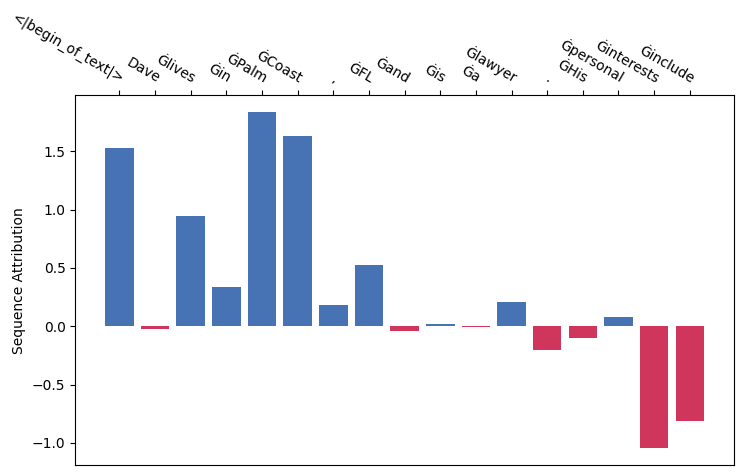

In [ ]:
inp = TextTokenInput(
    eval_prompt,
    tokenizer,
    skip_tokens=skip_tokens,
)

attr_res = llm_attr.attribute(inp, target=target, skip_tokens=skip_tokens)

attr_res.plot_seq_attr(show=True)

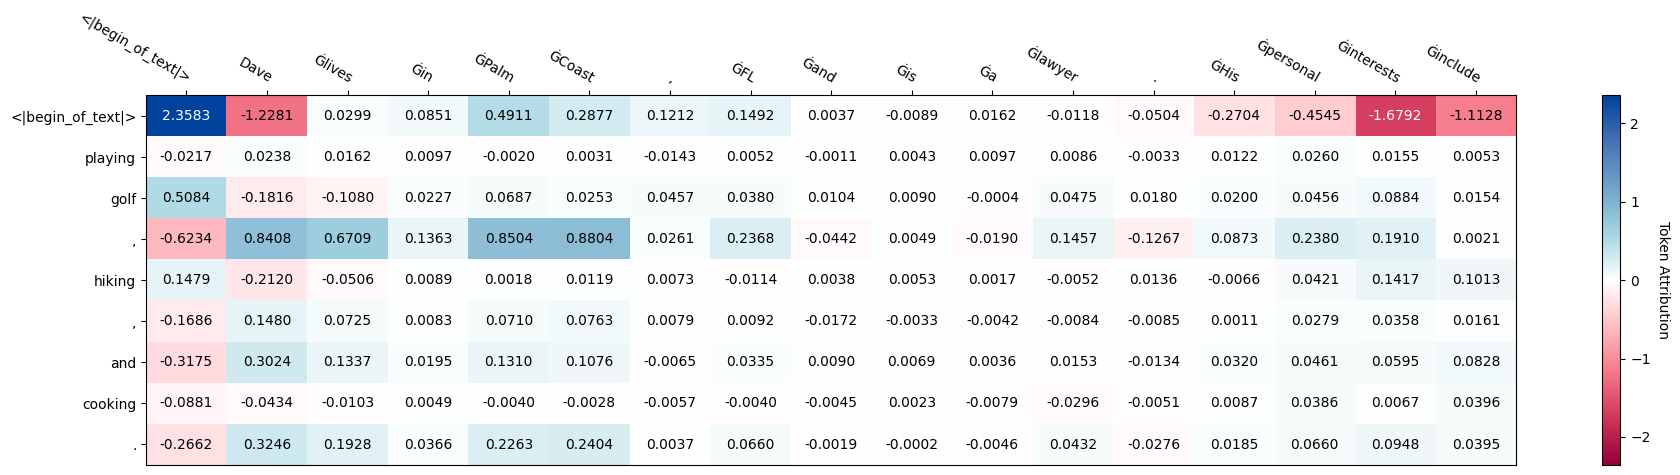

In [ ]:
attr_res.plot_token_attr(show=True)

Keep in mind that the token- and sequence-wise attribution will change layer to layer. We encourage you to explore how this attribution changes with alternative layers in the LLM.

>TODO
You can toy with this by changing the prompt and the target to see what you get.

## LLM explanation using LXT

In [3]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import modeling_llama
from transformers import BitsAndBytesConfig

from lxt.efficient import monkey_patch
from lxt.utils import pdf_heatmap, clean_tokens

We will try to explain LLM using a different paradigm: LRP (Layer-wise Relevance propagation).

We use here the package [LXT](https://lxt.readthedocs.io/en/latest/index.html) that handle attention layers for LRP.

To compute LRP in the backward pass, we need to modify the LLaMA module. Let’s apply the `monkey_patch` function.

In [4]:
# modify the LLaMA module to compute LRP in the backward pass
monkey_patch(modeling_llama, verbose=True)

Patched LlamaMLP
Patched LlamaRMSNorm
Patched Dropout
Patched transformers.models.llama.modeling_llama


We’ll load the LLaMA model and enable gradient checkpointing to save memory.

LXT also works for quantized models! However, the relevances should be accumulated in `torch.bfloat16` to prevent numerical errors.

In [5]:
# optional 4bit quantization 
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 to prevent overflow in gradients
)

path = 'meta-llama/Llama-3.2-1B-Instruct'
model = modeling_llama.LlamaForCausalLM.from_pretrained(path,
                                                        device_map='cuda',
                                                        dtype=torch.bfloat16,
                                                        quantization_config=quantization_config)

tokenizer = AutoTokenizer.from_pretrained(path)

To optimize memory usage, we’ll deactivate gradients on the model parameters. Optionally, we activate gradient checkpointing, which will perform 2x forward and 1x backward passes. We set the model into `train()` mode, because right now Huggingface does not allow to activate gradient checkpointing in `eval()` mode.

In [6]:
# optional gradient checkpointing to save memory (2x forward pass)
model.train()
model.gradient_checkpointing_enable()

# deactive gradients on parameters to save memory
for param in model.parameters():
    param.requires_grad = False



In [7]:
# Define the prompt

prompt = """Context: Mount Everest attracts many climbers, including highly experienced mountaineers. There are two main climbing routes, one approaching the summit from the southeast in Nepal (known as the standard route) and the other from the north in Tibet. While not posing substantial technical climbing challenges on the standard route, Everest presents dangers such as altitude sickness, weather, and wind, as well as hazards from avalanches and the Khumbu Icefall. As of November 2022, 310 people have died on Everest. Over 200 bodies remain on the mountain and have not been removed due to the dangerous conditions. The first recorded efforts to reach Everest's summit were made by British mountaineers. As Nepal did not allow foreigners to enter the country at the time, the British made several attempts on the north ridge route from the Tibetan side. After the first reconnaissance expedition by the British in 1921 reached 7,000 m (22,970 ft) on the North Col, the 1922 expedition pushed the north ridge route up to 8,320 m (27,300 ft), marking the first time a human had climbed above 8,000 m (26,247 ft). The 1924 expedition resulted in one of the greatest mysteries on Everest to this day: George Mallory and Andrew Irvine made a final summit attempt on 8 June but never returned, sparking debate as to whether they were the first to reach the top. Tenzing Norgay and Edmund Hillary made the first documented ascent of Everest in 1953, using the southeast ridge route. Norgay had reached 8,595 m (28,199 ft) the previous year as a member of the 1952 Swiss expedition. The Chinese mountaineering team of Wang Fuzhou, Gonpo, and Qu Yinhua made the first reported ascent of the peak from the north ridge on 25 May 1960. \
Question: How high did they climb in 1922? According to the text, the 1922 expedition reached 8,"""

We compute now the gradients with respect to the input embeddings. PyTorch can’t compute gradients for int64 tensors like `inputs_ids`, hence we use the bfloat16 `inputs_embeds`.

In [8]:
# Get input embeddings
input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to(model.device)
input_embeds = model.get_input_embeddings()(input_ids)

Make sure to activate gradient tracing for the input embeddings with `.requires_grad_()`

In [9]:
# Inference
output_logits = model(inputs_embeds=input_embeds.requires_grad_(), use_cache=False).logits

# Take the maximum logit at last token position. You can also explain any other token, or several tokens together!
max_logits, max_indices = torch.max(output_logits[0, -1, :], dim=-1)

# Backward pass (the relevance is initialized with the value of max_logits)
max_logits.backward()

# Obtain relevance. (Works at any layer in the model!)
relevance = (input_embeds.grad * input_embeds).float().sum(-1).detach().cpu()  # Cast to float32 for higher precision

In [10]:
# normalize relevance between [-1, 1] for plotting
relevance = relevance / relevance.abs().max()

# remove special characters from token strings and plot the heatmap
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens = clean_tokens(tokens)



If you have `xelatex` installed on your destop, run the following

In [ ]:
pdf_heatmap(tokens, relevance, path='llama_3.2_1B_instruct_heatmap.pdf', backend='xelatex') # backend='xelatex' supports more characters

Otherwise, run this to plot to get your prompt printed inline in the notebook, with each token highlighted depending on its importance.

In [19]:
import numpy as np
from IPython.display import HTML, display

def show_relevance_html(tokens, relevance, max_abs=None):
    """
    Display tokens inline in the notebook with background color
    proportional to their relevance.

    tokens: list[str]
    relevance: 1D tensor/array of scores (can be positive/negative)
    max_abs: if None, use max(|relevance|) for normalization
    """

    # to numpy
    if hasattr(relevance, "detach"):
        relevance = relevance.detach().cpu().numpy()
    else:
        relevance = np.asarray(relevance)

    assert len(tokens) == len(relevance), "tokens and relevance must have same length"

    # normalization
    if max_abs is None:
        max_abs = np.max(np.abs(relevance)) + 1e-8
    scores = relevance / max_abs  # now roughly in [-1, 1]

    def score_to_rgba(s):
        """
        Map score in [-1, 1] to a background color.
        - negative: red
        - positive: blue
        - near 0: almost white
        """
        s = float(np.clip(s, -1.0, 1.0))
        alpha = abs(s)

        if s > 0:
            # blueish for positive
            r, g, b = 100, 100, 255
            r, g, b = 255, 0, 0
        else:
            # reddish for negative
            r, g, b = 255, 100, 100
            r, g, b = 0, 0, 255

        # fade towards white as |s| -> 0
        r = int(255 * (1 - alpha) + r * alpha)
        g = int(255 * (1 - alpha) + g * alpha)
        b = int(255 * (1 - alpha) + b * alpha)

        return f"rgba({r}, {g}, {b}, 0.7)"

    spans = []
    for tok, s in zip(tokens, scores):
        # basic HTML escaping
        safe_tok = (
            tok.replace("&", "&amp;")
               .replace("<", "&lt;")
               .replace(">", "&gt;")
        )

        color = score_to_rgba(s)
        span = (
            f"<span style='background-color:{color}; "
            f"padding:2px 3px; margin:1px; border-radius:3px; "
            f"font-family:monospace;'>"
            f"{safe_tok}</span>"
        )
        spans.append(span)

    html = "<div style='line-height:1.8; font-size:13px;'>" + " ".join(spans) + "</div>"
    display(HTML(html))


In [20]:
show_relevance_html(tokens, relevance[0])

>TODO:
Change the prompt and see what you get as the most important tokens.